# Build Network

To run a simulation with `BrainPy`, users will mainly use three classes: two fundamental classes `brainpy.NeuGroup` and `brainpy.SynConn`, which refers to groups of neurons and synapses, respectively; and class `brainpy.Network`, with which users can build a neural network and simulate the whole network as an ensemble. 

In [build neurons](https://brainpy.readthedocs.io/en/latest/tutorials/build_neurons.html) and [build synapses](https://brainpy.readthedocs.io/en/latest/tutorials/build_synapses.html), we have already introduced how to define `brainpy.NeuType` and `brainpy.SynType`. Base on former introductions, in this section, we will first introduce `brainpy.NeuGroup` and `brainpy.SynConn`, then transition to the contruction and simulation of neural networks with `brainpy.Network`.

In [9]:
import brainpy as bp
import bpmodels
import numpy as np
import matplotlib.pyplot as plt

-----------------------------------------

## brainpy.NeuGroup

Users can implement a group of neurons as an object of `NeuGroup` class. Five input parameters are provided to the class contructor to describe the neuron group:

- `model`: The neuron models used to generate the neuron group.
- `geometry`: Geometry of the neuron group. Can be a int or a two-tuple of int.
- `pars_update`: Parameters to update. (??? is this clear?)
- `monitors`: List of ST members to monitor. 
- `name`: Name of neuron group. Will be automatically assigned if not given.

Example code:

    neu_group_1 = bp.NeuGroup(model=LIF, geometry=(10, ), monitors=['V'])

Parameter `geometry` represents the geometry of the neuron group users build. As `BrainPy` supports one-dimensional and two-dimensional neuron structure, `geometry` should be a int or a (int, int) tuple.

Parameter `monitors` includes the ST members that will be recorded during simulation. If a ST member is listed in `monitors`, its time series will be saved in variable `<NEU_GROUP_NAME>.mon.<MEM_NAME>` for later use.

Example code:

    V_time_series = neu.mon.V[START_TIME:END_TIME, NEURON_NO]

`NeuGroup` supports index and slice operation, both for one-dimensional and two-dimensional geometry. Users can include all the neurons of the same model in one neuron group, then operate different subgroups of it.

Example code:
    
    neu_group_2 = bp.NeuGroup(model = LIF, geometry = (100, 100))
    sub_group_1 = neu_group_2[:50]
    sub_group_2 = neu_group_2[:5, :5]
    syn_conn_1 = bp.SynConn(model = AMPA, 
                            pre_group = sub_group_2, 
                            post_group = neu_group_2[:10, :10],
                            conn = bp.connect.All2All())

Users can schedule the order to run subfunctions in the neuron groups with member function `runner.set_schedule`. The input parameter of function `set_schedule` is a list of the functions users and `BrainPy` utilized in the model.

Example code:

    neu.runner.set_schedule(['input', 'update', 'monitor', 'reset'])

Users can set parameters and initialize ST members after building neuron group. BrainPy also support heterogeneous parameter assignment: users can assign different values to the same ST member or parameter of different neurons in a neuron group.

Example code:
    
    neu_group_1.pars['V_rest'] = np.random.randint(0, 2, size=(10,))
    
    neu_group_1.ST['V'] = -65.

----------------------------------------------

## brainpy.SynConn

Users implement a group of synapses as an object of `SynConn` class. Nine input parameters are provided to the class contructor to describe the synapse connections:

- `model`: The neuron models used to generate the neuron group.
- `pars_update`: Parameters to update. (??? is this clear?)
- `pre_group`: Pre-synaptic neuron group.
- `post_group`: Post-synaptic neuron group.
- `conn`: Connection method to create synaptic connectivity.
- `num`: Number of synapses.
- `delay`: Time of synaptic delay.
- `monitors`: List of ST members to monitor. 
- `name`: Name of neuron group. Will be automatically assigned if not given.

`BrainPy` implements two ways to define a set of synapse connection:

-- 1. Assign values to the parameters `pre_group`, `post_group` and `conn`, and leave the parameter `num` blank. In this case, `pre_group` and `post_group` are two objects of `NeuGroup` class, and parameter `conn` specifies the connection strategy `BrainPy` will use to build synapses.

Eample code:

    gabaa = bp.SynConn(model=GABAa_syn, pre_group=pre, post_group=post, 
                       conn=bp.connect.All2All(), monitors=['s'], delay=10.)

-- 2. Assign value to the parameter `num`, leave the parameters `pre_group`, `post_group` and `conn` blank. After `SynConn` object has been defined, users should assign value to four members of `SynConn`: `pre`, `post`, `pre2syn` and `post2syn`. In this case, `num` refers to the number of synapses, `pre` and `post` choose which neurons are to be connected, `pre2syn` and `post2syn` map the synapse and the pre-synaptic, post-synaptic neurons.

Example code:

    syn = bp.SynConn(model = syn_model, num = delta_t_num, 
                      monitors = ['w'], delay = 10.)
    syn.pre = bp.types.NeuState(['spike'])(2)
    syn.post = bp.types.NeuState(['V', 'input', 'spike'])(2)
    pre2syn_list = [[1, 1], [2, 2]]
    post2syn_list = [[1, 1], [2, 2]]
    syn.pre2syn = syn.requires['pre2syn'].make_copy(pre2syn_list)
    syn.post2syn = syn.requires['post2syn'].make_copy(post2syn_list)

Parameter `delay` refers to the synapse delay time. According to the biological nature of synapses, there is a time delay between the moment pre-synaptic spike affects the synapse state and the moment synapse state affects the post-synaptic spike. `BrainPy` realizes this delay with decorator `@brainpy.delayed`, and it will be automatically computed with proper defination of `NeuType` (See [build synapses](https://brainpy.readthedocs.io/en/latest/tutorials/build_synapses.html) for detail).

Parameter `monitors` includes the ST members that will be recorded during simulation. If a ST member is listed in `monitors`, its time series will be saved in variable `<NEU_GROUP_NAME>.mon.<MEM_NAME>` for later use.

Example code:

    w_time_series = syn.mon.w[START_TIME:END_TIME, NEURON_NO]

Users can schedule the order to run subfunctions in the synapse connections with member function `runner.set_schedule`. The input parameter of function `set_schedule` is a list of the functions users and `BrainPy` utilized in the model.

Example code:

    syn.runner.set_schedule(['input', 'update', 'output', 'monitor'])

Users can set parameters and initialize ST members after building synapse connections. BrainPy also support heterogeneous parameter assignment: users can assign different values to the same ST member or parameter of different synapses in a synapse connection.

Example code:
    
    syn_conn_1.pars['w'] = np.random.rand(syn_num)

-------------------

## brainpy.Network

To initialize a neural network, i.e. an object of `brainpy.Network` class, a list of `NeuGroup` and `SynConn` objects should be provided to the `Network` constructor as input parameters. These objects will compose the network.

- `*args`: List of objects.
- `mode`: If the model will be simulated repeatly.
- `**kwargs`: List of object names. If this parameter is not provided, the object will be automatically named.

These objects can be accessed via their names, e.g. `NET_NAME.OBJ_NAME`.

Example code:

    net = bp.Network(neu_group_1, neu_group_2, syn_conn_1, syn_conn_2)

### add

Users can add objects to the network using member function `add` of class `Network` after initialization is done. Input parameters of function `add` is similar to the ones of constructors function.

- `*args`: List of objects.
- `**kwargs`: List of object names. If this parameter is not provided, the object will be automatically named.

### run

`BrainPy` run simulation with member function `run` of class `Network`.

- `duration` : The amount of simulation time (ms) to run for.
- `inputs` : List of external inputs, each element is a quadruple of (receiver, item, external input, [operation]), operation is set to '+' by default if not given. Default = ().
- `report` : Report the progress of the simulation. Default = false.
- `report_percent` : The interval of simulation progress reporting. Default = 0.1.

The items of `inputs` quadruple:

- `receiver`: The `NeuGroup` or `SynConn` object that receives the input.
- `item`: Specific item of the receiver that receives the input.
- `external input`: Description of the input time series.
- `operation`: Which operation should the item take when it receives the input.

`BrainPy` supports diverse input methods. The `operation` item can be set as one of { + , - , * , / , = }, and if users do not provide this item explictly, it will be set to '+' by default. The value of `operation` defines in which way the input will be given to the receive item. Generally, users can see it as a binary operator. For example, if `operation == '+'`, then in a single update, the value of receive item `val = val + input`.

Example code:

    net.run(duration=100., inputs=[(neu_group_1, 'ST.input', 1.)], report=True)

After calling `run` function, `NeuGroup` and `SynConn` objects in the network will be updated in the way they were defined in their description, and in the order they were provided to the `Network` constructor as input parameters. We should mention that this order barely affects the simulation result, because the update interval `dt` are relatively small, therefore single update will not cause a sharp change in variable values.

Note:

> i. Users can directly run `NeuGroup` with member function `NeuGroup.run`. However, `SynConn` can not be run in this way. See more details in [build neurons](https://brainpy.readthedocs.io/en/latest/tutorials/build_neurons.html) and [build synapses](https://brainpy.readthedocs.io/en/latest/tutorials/build_synapses.html).

> ii. Although the calculation order barely affects the simulation progress, users should be aware of the order and deal with relative assignments carefully, otherwise this feature may cause a bug.

---------------------------------------------------------------------

## E/I balance network

We take E/I balance network as an example. E/I balance network is a canonical network model, in which the populations of excitatory and inhibitory neurons achieve an approximate balance.

In [10]:
# set global parameters
bp.profile.set(jit=True, device='cpu',
               numerical_method='exponential')

num_exc = 500
num_inh = 500
prob = 0.1

Neuron model is defined as:

$$ \tau \frac{d V}{d t} = -(V - V_{rest} + I^{ext} + I^{net}(t))$$

With a threshold of `-50mV` and a refractory of `5ms` .

In [11]:
# define neuron model as bp.NeuType
V_rest = -52.
V_reset = -60.
V_th = -50.
R=1.
tau=10.
t_refractory=5.
noise=0.

ST_neu = bp.types.NeuState(
             {'V': 0, 'input': 0, 'spike': 0, 'refractory': 0, 't_last_spike': -1e7}
         )

@bp.integrate
def int_V(V, _t, I_ext):  # integrate u(t)
    return (- (V - V_rest) + R * I_ext) / tau, noise / tau

def update(ST, _t):
    # update variables
    ST['spike'] = 0
    if _t - ST['t_last_spike'] <= t_refractory:
        ST['refractory'] = 1.
    else:
        ST['refractory'] = 0.
        V = int_V(ST['V'], _t, ST['input'])
        if V >= V_th:
            V = V_reset
            ST['spike'] = 1
            ST['t_last_spike'] = _t
        ST['V'] = V
    
def reset(ST):
    ST['input'] = 0.


neu = bp.NeuType(name='LIF',
                 ST=ST_neu,
                 steps=(update, reset),
                 mode='scalar')

Synapse model is defined as:

\begin{equation}
\label{eq6}
f(t) =\left\{
\begin{aligned}
exp(-\frac{t}{\tau_s}) & , & t \geq 0 , \\
0 & , & t < 0.
\end{aligned}
\right.
\end{equation}

$$ I^{net}(t) = J_E \sum_{j=1}^{p N_E}\sum_{t_j^\alpha < t}f(t - t_j^\alpha) - J_I \sum_{j=1}^{pN_I}\sum_{t_j^\alpha < t}f(t - t_j^\alpha)$$

In [12]:
# define synapse model as bp.SynType
tau_decay = 2.
JE = 1 / np.sqrt(prob * num_exc)
JI = 1 / np.sqrt(prob * num_inh)

ST_syn = bp.types.SynState({'s':0., 'w': .1, 'g':0.}, help='synapse state.')

@bp.integrate
def ints(s, t):
    return - s / tau_decay


def update(ST, _t, pre):
    s = ints(ST['s'], _t)
    s += pre['spike']
    ST['s'] = s
    ST['g'] = ST['w'] * s


def output(ST, post):
    post['input'] += ST['g']


syn = bp.SynType(name='alpha_synapse',
                 ST=ST_syn,
                 steps=(update, output),
                 mode='scalar')

After neuron model and synapse model are built, we generate the concrete neuron group and synapse connections. Note that we assign heterogeneous initial values to ST members, and build synapse connections between two subgroups of one neuron group using the slice operation.

In [13]:
# generate bp.NeuGroup & bp.SynConn
group = bp.NeuGroup(neu, geometry=num_exc + num_inh, monitors=['spike'])

group.ST['V'] = np.random.random(num_exc + num_inh) * (V_th - V_rest) + V_rest

exc_conn = bp.SynConn(syn,
                      pre_group=group[:num_exc],
                      post_group=group,
                      conn=bp.connect.FixedProb(prob=prob))
exc_conn.ST['w'] = JE

inh_conn = bp.SynConn(syn,
                      pre_group=group[num_exc:],
                      post_group=group,
                      conn=bp.connect.FixedProb(prob=prob))
exc_conn.ST['w'] = -JI

To integrate the neuron groups and synapse connection into a network, we initialize an object of `brainpy.Network` class with these previous defined objects, then run the network with member function `run`. In this progress, we simulate the network for 500 ms, give a constant input of amplitude `3.` to all the neurons in neuron group, and report the simulation progress.

In [14]:
net = bp.Network(group, exc_conn, inh_conn)
net.run(duration=500., inputs=(group, 'ST.input', 3.), report=True)

Compilation used 0.5022 s.
Start running ...
Run 10.0% used 0.088 s.
Run 20.0% used 0.174 s.
Run 30.0% used 0.275 s.
Run 40.0% used 0.393 s.
Run 50.0% used 0.483 s.
Run 60.0% used 0.577 s.
Run 70.0% used 0.665 s.
Run 80.0% used 0.770 s.
Run 90.0% used 0.857 s.
Run 100.0% used 0.942 s.
Simulation is done in 0.942 s.


After visualization, users can see the typical oscillation pattern of E/I balance network.

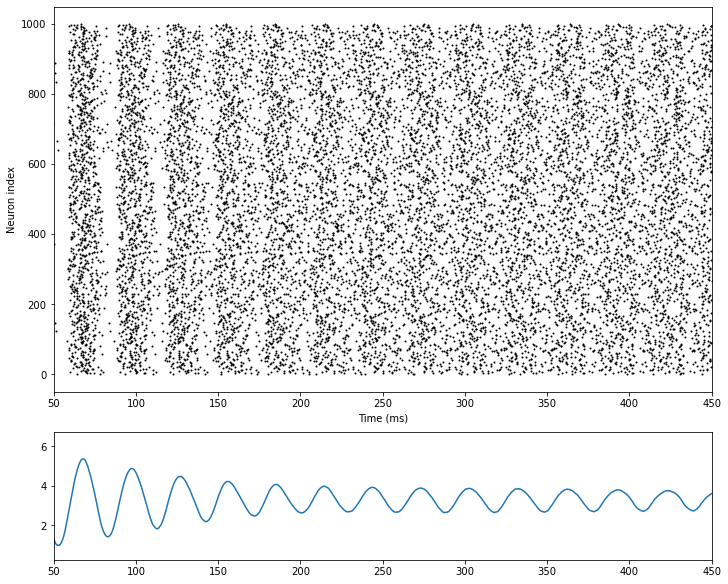

In [16]:
fig, gs = bp.visualize.get_figure(4, 1, 2, 10)

fig.add_subplot(gs[:3, 0])
bp.visualize.raster_plot(net.ts, group.mon.spike, xlim=(50, 450))

fig.add_subplot(gs[3, 0])
rates = bp.measure.firing_rate(group.mon.spike, 5.)
plt.plot(net.ts, rates)
plt.xlim(50, 450)
plt.show()